# Comparing tweet categories between two sets of tweets

Use Twitter API to analyze **similarities** and **differences** between people tweeting about A vs people tweeting about B.

1. word cloud of words in tweets relating to category A and to category B
2. topic modelling of the words
3. geolocation of tweets and plot on map? (next)

In [2]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from gensim import corpora # vectorising words
from gensim.models.tfidfmodel import TfidfModel #tfidf model from gensim
from gensim.models import LsiModel, LdaModel # lsi, lda model

import pyLDAvis.gensim, pyLDAvis # visualisation tool for lda

import os # os calls
import tweepy # python wrapper for api
import pickle # loading variables
import re # text processing
import string # text processing helper methods

import pandas as pd
import seaborn as sns # prettify plots

C:\Users\Mysterial\Miniconda3\envs\thinx\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
with open('twitter_access_token.pkl', 'rb') as p:
    access = pickle.load(p)

In [3]:
token = ['', ''] # consumer key, consumer secret
access = ['', ''] # access key, access secret

try:
    if any([len(key)==0 for keys in zip(token, access) for key in keys]): # check if any entries of token or access are strings of length 0
        with open('twitter_consumer_token.pkl', 'rb') as p:
            token = pickle.load(p)
        with open('twitter_access_token.pkl', 'rb') as p:
            access = pickle.load(p)
except FileNotFoundError:
    raise Exception('Fill in the token and access fields in the script.')

In [4]:
auth = tweepy.OAuthHandler(*token)
auth.set_access_token(*access)

api = tweepy.API(auth)

In [5]:
# searching for tweets with specified queries
a_query = tweepy.Cursor(api.search, q='machine learning', tweet_mode='extended')
b_query = tweepy.Cursor(api.search, q='artifical intelligence', tweet_mode='extended')

In [6]:
def tweet_data(title, query, count=100, force=False, refresh=False):
    # force: switch for overriding pickled data
    # refresh: switch for refreshing data to the latest
    if title + '.pkl' not in os.listdir() or refresh:
        data = []
        for x in query.items(count):
            data.append(x)
        if force:
            with open(title + '.pkl', 'wb') as p:
                pickle.dump(data, p)
    else:
        with open(title + '.pkl', 'rb') as p:
            data = pickle.load(p)
    return data

a_data = tweet_data('a', a_query, count=400, refresh=True)
b_data = tweet_data('b', b_query, count=400, refresh=True)

In [128]:
# change to lowercase, remove url, remove all punctuation except hashtags
def clean(text):
    text = ''.join(char for char in text if char in string.printable) # filtered by individual character matching on ascii table
    text = text.lower() # lowercase
    text = re.sub('https?://[^ ]*', '', text) # remove urls
    punc = '[' + re.escape(string.punctuation.replace('#', '')) + ']' # remove punctuation from text, except hashtags
    text = re.sub(punc, '', text)
    text = re.sub(' +', ' ', text) # remove duplicate spaces
    text = text.strip() # remove trailing spaces
    return text

def tweet_extract(tweetobj, retweet=False):
    if not retweet: # remove retweets, looking for unique tweets only
        if tweetobj.retweeted or 'RT @' in tweetobj.full_text:
            return None
    return clean(tweetobj.full_text)

In [8]:
# split tweets into a list of string where each string represents each tweet
a_tweets = [tweet_extract(obj) for obj in a_data if tweet_extract(obj) is not None and len(tweet_extract(obj)) > 0]
b_tweets = [tweet_extract(obj) for obj in b_data if tweet_extract(obj) is not None and len(tweet_extract(obj)) > 0]
a_tweets = list(set(a_tweets))
b_tweets = list(set(b_tweets))

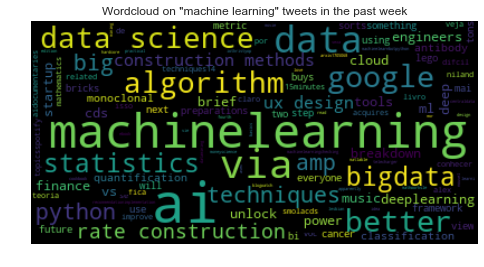

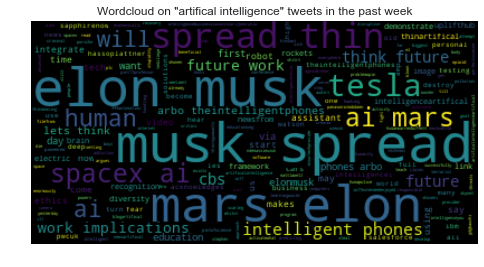

In [9]:
stopwords = set(STOPWORDS)
stopwords.update({'machine', 'learning', 'artificial', 'intelligence', 'artifical'})

# lower max_font_size
wordcloud = WordCloud(max_font_size=50, stopwords=stopwords).generate((''.join(a_tweets)))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Wordcloud on "machine learning" tweets in the past week')
plt.axis("off")
plt.show()

wordcloud = WordCloud(max_font_size=50, stopwords=stopwords).generate((''.join(b_tweets)))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Wordcloud on "artifical intelligence" tweets in the past week')
plt.axis("off")
plt.show()

### tf-idf on tweets

**Pipeline** <br>
1. split each tweet into a list of words; \_ = [x.split for x in tweets] <br>
2. create a dict of words; dict = corpora.Dictionary(\_)<br>
3. create token maps for dict; tokens = dict.token2id<br>
4. convert tweet to vectors; corpus = [dict.doc2bow(x) for x in \_]<br>
5. create model; model = TfidfModel(corpus=corpus) <br>
6. obtain tfidf scores; \_ = model[tokens] <br>
7. convert tokens back to words; tfidf\_token2id[\_]

In [10]:
stopwords = set(STOPWORDS)
stopwords.update({'machine', 'learning', 'artificial', 'intelligence', 'artifical'})

# create a dict of tweet words
def dictionary(tweets):
    return corpora.Dictionary(tweets)

# tokenise tweets using corpora.Dictionary
def tokenise_corpus(tweets, dictionary):
    return [dictionary.doc2bow(tweet) for tweet in tweets]

# # tokenise tweets using corpora.Dictionary
# def tokenise_corpus(tweets, dictionary):
#     return [dictionary.doc2bow(tweet.split()) for tweet in tweets]

# training a tfidf model
def tfidf_model(tokenised_corpus):
    return TfidfModel(corpus=tokenised_corpus)

# use a tfidf model to transform the tokenised tweets to tfidf tweets
def tfidf_corpus(model, tokenised_corpus):
    return model[tokenised_corpus]

def tfidf_token2id(tfidf_corpus, dictionary):
    '''
    This function takes in the generator expression from TfidfModel(corpus)[corpus] and outputs a dictionary of word-tfidf score
    '''
    id2tfidf = {}

    for line in tfidf_corpus:
        for ID, freq in line:
            pair = {dictionary.get(ID): freq}
            id2tfidf.update(pair)
    return id2tfidf

# a class that contains all the outputs that are useful for tf-idf, lsi, lda from gensim
class corpora_pipe(object):
    def __init__(self, tweets, stopwords):
        """ valid methods: tweets, stopwords, dict, tokens
        """
        tweets = [tweet for tweet in tweets if len(tweet.split()) > 4] # removes tweets if the word count is < 5
        self.tweets = [[word for word in tweet.split() if word not in stopwords] for tweet in tweets] # split tweets, remove words in stopwords
        self.stopwords = stopwords
        self.dict = dictionary(self.tweets)
        self.tokens = tokenise_corpus(self.tweets, self.dict)

# a tfidf pipeline that inherits from corpora_pipe, returns word: tfidf frequency and excluded stopwords
class tfidf_pipeline(corpora_pipe):
    def __init__(self, tweets, stopwords):
        corpora_pipe.__init__(self, tweets, stopwords)
        self.model = tfidf_model(self.tokens)
        self.corpus = list(tfidf_corpus(self.model, self.tokens))
        self.tfidf = tfidf_token2id(self.corpus, self.dict)
    def transform(self):
        return self.tfidf

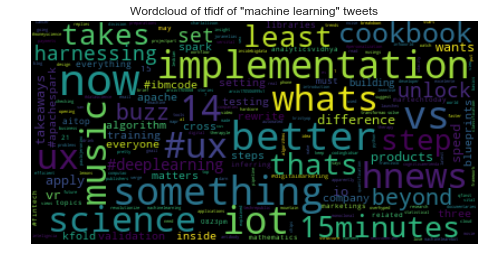

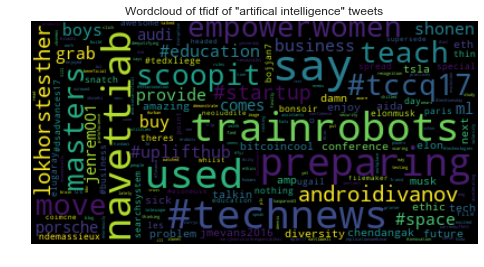

In [14]:
plt.imshow(WordCloud(max_font_size=40, stopwords=stopwords).generate_from_frequencies(frequencies=tfidf_pipeline(a_tweets, stopwords).transform()), interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of tfidf of "machine learning" tweets')
plt.show()

plt.imshow(WordCloud(max_font_size=40, stopwords=stopwords).generate_from_frequencies(frequencies=tfidf_pipeline(b_tweets, stopwords).transform()), interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of tfidf of "artifical intelligence" tweets')
plt.show()

### LSI

In [15]:
a_tfidf = tfidf_pipeline(a_tweets, stopwords)
b_tfidf = tfidf_pipeline(b_tweets, stopwords)
a_lsi = LsiModel(a_tfidf.corpus, id2word=a_tfidf.dict, num_topics=5)
corpus_list = a_lsi[a_tfidf.corpus]
# for topic in corpus_list:
#     print(topic)

In [16]:
# distinct topics, similar to pca
a_lsi.show_topics(num_words=5)

[(0,
  '-0.418*"better" + -0.288*"#ai" + -0.274*"#machinelearning" + -0.259*"data" + -0.255*"matters"'),
 (1,
  '-0.411*"methods" + -0.411*"rate" + -0.411*"construction" + -0.411*"cds" + -0.391*"techniques"'),
 (2,
  '0.495*"matters" + 0.484*"design" + 0.428*"ux" + 0.221*"hnews" + -0.218*"better"'),
 (3,
  '0.303*"bricks" + 0.303*"man" + 0.303*"tons" + 0.303*"metric" + 0.303*"two"'),
 (4,
  '-0.374*"google" + -0.333*"ai" + 0.312*"better" + -0.205*"science" + -0.175*"everyone"')]

### LDA

In [ ]:
# ldavis -visualise the topics for each set of corpus separately, but how do you analyse the similarities and differences?
# maybe: plot both corpus together and then tag the tweets with topics
# semantic distance between topics on scatterplot

In [20]:
full_tweets = a_tweets + b_tweets
# merge the two corpuses together, generate ldavis on the combined corpus, 
# circle colour shade of hue depending on how many belong to one class

a_pipe = corpora_pipe(a_tweets, stopwords)
full_pipe = corpora_pipe(full_tweets, stopwords)

%time full_lda = LdaModel(full_pipe.tokens, num_topics=5, \
                     id2word=full_pipe.dict, \
                     passes = 100)

Wall time: 17.9 s
Wall time: 30.8 s


In [18]:
pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.gensim.prepare(topic_model=full_lda, corpus=full_pipe.tokens, dictionary=full_pipe.dict)
pyLDAvis.display(lda_vis)
# d3 visualisation available at
# https://nbviewer.jupyter.org/github/aerymilts/comparative-tweets/blob/master/comparative-tweets.ipynb#LDA

In [ ]:
# sns stacked barplot of all the topics with the proportion of tweets in each topic

In [118]:
a_df = pd.DataFrame([{topic: prob for topic, prob in tweet} for tweet in list(full_lda.get_document_topics(full_pipe.tokens[:len(a_pipe.tokens)]))])
b_df = pd.DataFrame([{topic: prob for topic, prob in tweet} for tweet in list(full_lda.get_document_topics(full_pipe.tokens[len(a_pipe.tokens):]))])
full_df = pd.DataFrame([{topic: prob for topic, prob in tweet} for tweet in list(full_lda.get_document_topics(full_pipe.tokens))])

In [131]:
# sanity check - stacked barplot should be the sum of these numbers for each topic
print(pd.DataFrame([{topic: prob for topic, prob in tweet} for tweet in list(full_lda.get_document_topics(a_pipe.tokens))]).sum(),
      '\n\n',
pd.DataFrame([{topic: prob for topic, prob in tweet} for tweet in list(full_lda.get_document_topics(full_pipe.tokens[len(a_pipe.tokens):]))]).sum())

0    15.397850
1    15.885164
2    13.246606
3    11.749497
4    11.720882
dtype: float64 

 0    21.451208
1    13.957254
2    32.433771
3    15.654451
4    17.503316
dtype: float64


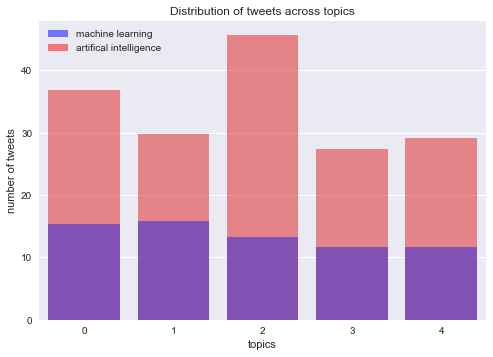

[(0,
  '0.023*"#ai" + 0.016*"#machinelearning" + 0.016*"phones" + 0.016*"#theintelligentphones" + 0.016*"panasonicmob"'),
 (1,
  '0.008*"will" + 0.008*"#python" + 0.006*"google" + 0.006*"data" + 0.006*"4"'),
 (2,
  '0.036*"spread" + 0.036*"thin" + 0.034*"musk" + 0.032*"elon" + 0.029*"ai"'),
 (3, '0.018*"ai" + 0.015*"now" + 0.012*"data" + 0.012*"better" + 0.009*"may"'),
 (4,
  '0.039*"future" + 0.019*"lets" + 0.017*"think" + 0.016*"rt" + 0.011*"ai"')]

In [48]:
sns.barplot(data=full_df.sum().to_frame().transpose(), color='red', alpha=0.5)
sns.barplot(data=a_df.sum().to_frame().transpose(), color='blue', alpha=0.5)
plt.xlabel('topics')
plt.ylabel('number of tweets')
fbar = plt.Rectangle((0,0),1,1, fc="red", edgecolor = 'none', alpha=0.5)
abar = plt.Rectangle((0,0),1,1, fc='blue',  edgecolor = 'none', alpha=0.5)
plt.legend([abar, fbar], ['machine learning', 'artifical intelligence'],
           loc=2)
plt.title('Distribution of tweets across topics')
plt.show()
full_lda.show_topics(num_words=5) # words associated with each topic

In [ ]:
# find another two topics to measure?